[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\ayush\AppData\Local\Temp\ipykernel_38100\2048872558.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

Loading data...
Disaster train shape: (7563, 6)
Disaster test shape: (3263, 4)
Sentiment data shape: (40000, 4)

Predicted label distribution in train:
predicted_label
0    3009
2    2671
1    1883
Name: count, dtype: int64
predicted_label
0    39.79%
2    35.32%
1    24.90%
Name: proportion, dtype: object
Preprocessing disaster data...


C:\Users\ayush\AppData\Local\Temp\ipykernel_38100\2048872558.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('', inplace=True)
C:\Users\ayush\AppData\Local\Temp\ipykernel_38100\2048872558.py:113: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

Building sentiment model...
Sentiment Model Accuracy: 0.324625
Extracting sentiment features...
Extracting text and categorical features...
Building multi-class disaster detection model...


C:\Users\ayush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:17:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test set doesn't have predicted_label column. Using binary target for basic evaluation if available.
No ground truth labels available for evaluation.
Prediction class distribution on test data:
0    1393
2    1285
1     585
Name: count, dtype: int64
Generating feature importance plot...


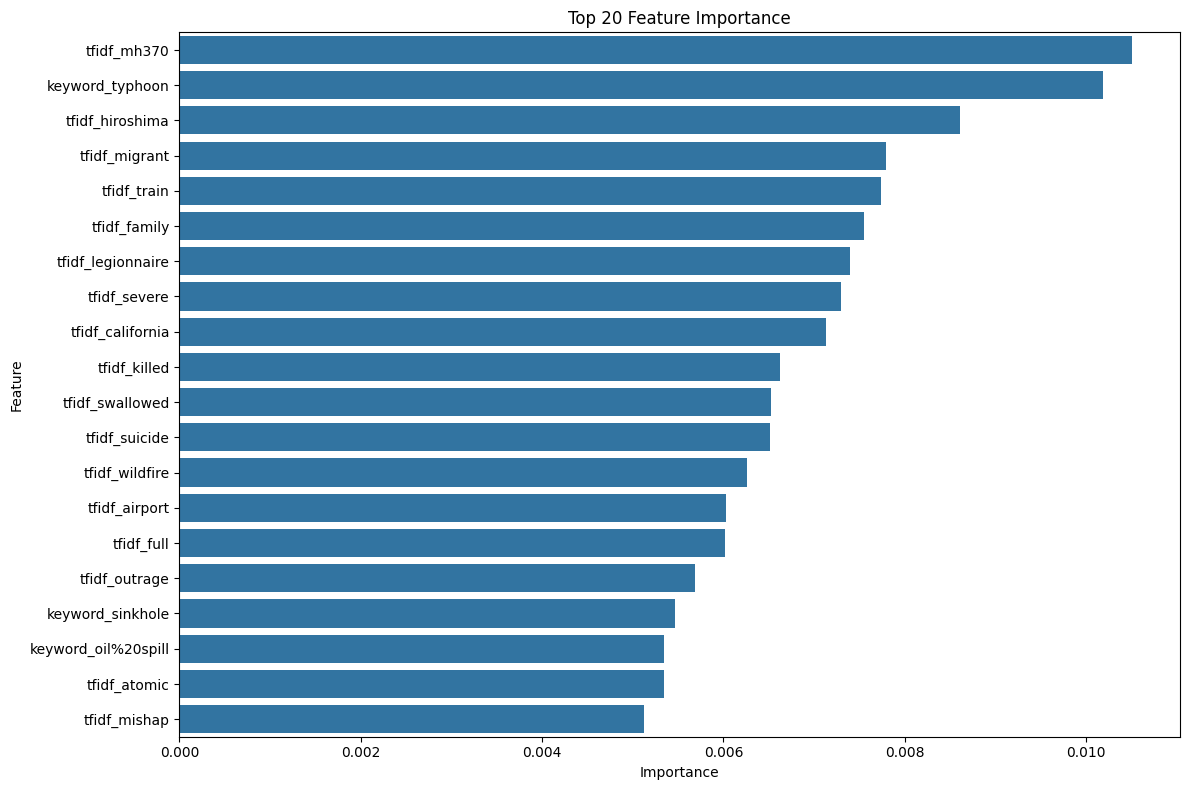

Saving model and preprocessing objects...
Pipeline completed. Multi-class model and preprocessing objects saved.


In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Download necessary NLTK packages
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# --- DATA LOADING ---
def load_data():
    """Load disaster and sentiment datasets"""
    # Load disaster training data with new predicted_label column
    # Update the path to your new dataset with the three-class labels
    disaster_train = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\combinedSarcasmDataset.csv')
    
    # Load original disaster test data (may not have predicted_label)
    # You can use either your original test dataset or the new one with predicted_label
    disaster_test = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\disasterTest.csv')
    
    # Load sentiment analysis data
    sentiment_data = pd.read_csv(r'C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\sentimentAnalysis.csv')
    
    # Print dataset info
    print(f"Disaster train shape: {disaster_train.shape}")
    print(f"Disaster test shape: {disaster_test.shape}")
    print(f"Sentiment data shape: {sentiment_data.shape}")
    
    # Check predicted_label distribution in training data
    if 'predicted_label' in disaster_train.columns:
        print("\nPredicted label distribution in train:")
        print(disaster_train['predicted_label'].value_counts())
        print(disaster_train['predicted_label'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))
    else:
        raise ValueError("Training dataset must contain a 'predicted_label' column")
    
    # Check if test data has predicted_label, if not show original target distribution
    if 'predicted_label' in disaster_test.columns:
        print("\nPredicted label distribution in test:")
        print(disaster_test['predicted_label'].value_counts())
    elif 'target' in disaster_test.columns:
        print("\nOriginal binary target distribution in test:")
        print(disaster_test['target'].value_counts())
    
    return disaster_train, disaster_test, sentiment_data

# --- TEXT PREPROCESSING ---
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (#topic)
    text = re.sub(r'#\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin into a single string
    clean_text = ' '.join(tokens)
    
    return clean_text

# --- FEATURE ENGINEERING ---
def preprocess_disaster_data(disaster_df, require_predicted_label=False):
    """Preprocess disaster dataset"""
    # Make a copy to avoid modifying the original
    df = disaster_df.copy()
    
    # Fill missing values
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)
    
    # Clean text
    df['clean_text'] = df['text'].apply(clean_text)
    
    # Check if predicted_label is present
    if 'predicted_label' in df.columns:
        # Verify predicted_label values are 0, 1, 2
        valid_labels = set([0, 1, 2])
        actual_labels = set(df['predicted_label'].unique())
        
        if not actual_labels.issubset(valid_labels):
            raise ValueError(f"predicted_label should only contain values 0, 1, 2. Found: {actual_labels}")
    elif require_predicted_label:
        raise ValueError("Dataset must contain a 'predicted_label' column")
    
    return df

def extract_features(df_train, df_test=None, tfidf_max_features=5000):
    """Extract features from preprocessed data"""
    # TF-IDF for text
    tfidf = TfidfVectorizer(max_features=tfidf_max_features)
    
    # Fit on training data
    X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
    
    # Transform test data if provided
    X_test_tfidf = None
    if df_test is not None:
        X_test_tfidf = tfidf.transform(df_test['clean_text'])
    
    # Get clean feature names (replace special characters)
    feature_names = []
    for name in tfidf.get_feature_names_out():
        # Replace special characters with underscores
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        feature_names.append(f'tfidf_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
    
    test_tfidf_df = None
    if X_test_tfidf is not None:
        test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)
    
    # Add keyword and location as features (one-hot encoded)
    categorical_features = ['keyword', 'location']
    
    # Initialize the encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit on training data
    encoder.fit(df_train[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            # Clean value and create a proper feature name
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    # Transform training data
    train_cat_encoded = encoder.transform(df_train[categorical_features])
    train_cat_df = pd.DataFrame(
        train_cat_encoded,
        columns=cat_feature_names
    )
    
    # Transform test data if provided
    test_cat_df = None
    if df_test is not None:
        test_cat_encoded = encoder.transform(df_test[categorical_features])
        test_cat_df = pd.DataFrame(
            test_cat_encoded,
            columns=cat_feature_names
        )
    
    # Combine all features
    X_train_features = pd.concat([train_tfidf_df, train_cat_df], axis=1)
    
    X_test_features = None
    if test_tfidf_df is not None and test_cat_df is not None:
        X_test_features = pd.concat([test_tfidf_df, test_cat_df], axis=1)
    
    return X_train_features, X_test_features, tfidf, encoder, feature_names, cat_feature_names

# --- SENTIMENT ANALYSIS ---
def build_sentiment_model(sentiment_data):
    """Build and train a sentiment analysis model"""
    # Clean text
    sentiment_data['clean_content'] = sentiment_data['content'].apply(clean_text)
    
    # Convert sentiment to numeric categories
    sentiment_mapping = {
        'empty': 0,
        'sadness': 1,
        'enthusiasm': 2,
        'neutral': 3,
        'worry': 4,
        'surprise': 5,
        'love': 6,
        'fun': 7,
        'hate': 8,
        'happiness': 9,
        'relief': 10,
        'anger': 11,
        'boredom': 12
    }
    
    sentiment_data['sentiment_code'] = sentiment_data['sentiment'].map(sentiment_mapping)
    
    # TF-IDF for sentiment text
    sentiment_tfidf = TfidfVectorizer(max_features=3000)
    X_sentiment = sentiment_tfidf.fit_transform(sentiment_data['clean_content'])
    
    # Get clean feature names
    sentiment_feature_names = []
    for name in sentiment_tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        sentiment_feature_names.append(f'sent_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    y_sentiment = sentiment_data['sentiment_code']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sentiment_df, y_sentiment, test_size=0.2, random_state=42
    )
    
    # Train a RandomForest for sentiment classification
    sentiment_model = RandomForestClassifier(n_estimators=100, random_state=42)
    sentiment_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = sentiment_model.predict(X_test)
    print("Sentiment Model Accuracy:", accuracy_score(y_test, y_pred))
    
    return sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names

def extract_sentiment_features(df, sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names):
    """Extract sentiment features from tweets"""
    # Clean text (if not already done)
    if 'clean_text' not in df.columns:
        df['clean_text'] = df['text'].apply(clean_text)
    
    # Transform text using sentiment TF-IDF
    X_sentiment = sentiment_tfidf.transform(df['clean_text'])
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    # Predict sentiment
    sentiment_pred = sentiment_model.predict(X_sentiment_df)
    
    # Get sentiment probabilities
    sentiment_proba = sentiment_model.predict_proba(X_sentiment_df)
    
    # Create a DataFrame with sentiment probabilities
    sentiment_columns = [f'sentiment_{key}' for key in sentiment_mapping.keys()]
    sentiment_df = pd.DataFrame(sentiment_proba, columns=sentiment_columns)
    
    # Add predicted sentiment class
    df['predicted_sentiment'] = sentiment_pred
    
    # Combine with sentiment probabilities
    result_df = pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
    
    return result_df

# --- MULTI-CLASS DISASTER DETECTION MODEL ---
def build_multiclass_disaster_model(X_train, y_train, model_type='xgboost'):
    """Build and train multi-class disaster detection model"""
    # Modified to handle multi-class problem (0, 1, 2)
    
    if model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=200, 
            max_depth=20, 
            random_state=42,
            class_weight='balanced'  # Handle class imbalance
        )
        model.fit(X_train, y_train)
        
    elif model_type == 'gradient_boosting':
        model = GradientBoostingClassifier(
            n_estimators=200, 
            max_depth=5, 
            random_state=42
        )
        model.fit(X_train, y_train)
        
    elif model_type == 'xgboost':
        # Multi-class classification with XGBoost
        model = xgb.XGBClassifier(
            n_estimators=200, 
            max_depth=5, 
            learning_rate=0.1, 
            random_state=42,
            enable_categorical=False,  # Disable categorical feature support
            use_label_encoder=False,   # Avoid label encoding warning
            tree_method='hist',        # Use histogram-based tree method
            objective='multi:softprob', # Multi-class objective
            num_class=3                # Number of classes (0, 1, 2)
        )
        model.fit(X_train, y_train)
        
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model

def evaluate_multiclass_model(model, X_test, y_test):
    """Evaluate the multi-class disaster detection model"""
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[
        "0: Disaster word, No Disaster", 
        "1: Disaster word and Disaster", 
        "2: Not Disaster"
    ]))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["0: Disaster word, No Disaster", "1: Disaster word and Disaster", "2: Not Disaster"],
                yticklabels=["0: Disaster word, No Disaster", "1: Disaster word and Disaster", "2: Not Disaster"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return y_pred, accuracy

# --- FEATURE IMPORTANCE ---
def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title(f'Top {top_n} Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print("Model doesn't have feature_importances_ attribute")

# --- MAIN PIPELINE ---
def main():
    # 1. Load Data
    print("Loading data...")
    disaster_train, disaster_test, sentiment_data = load_data()
    
    # Check if train data has the predicted_label column
    if 'predicted_label' not in disaster_train.columns:
        raise ValueError("Training dataset must contain a 'predicted_label' column")
    
    # 2. Preprocess Disaster Data
    print("Preprocessing disaster data...")
    disaster_train_processed = preprocess_disaster_data(disaster_train, require_predicted_label=True)
    disaster_test_processed = preprocess_disaster_data(disaster_test, require_predicted_label=False)
    
    # 3. Build Sentiment Model
    print("Building sentiment model...")
    sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names = build_sentiment_model(sentiment_data)
    
    # 4. Extract Sentiment Features
    print("Extracting sentiment features...")
    disaster_train_with_sentiment = extract_sentiment_features(
        disaster_train_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    disaster_test_with_sentiment = extract_sentiment_features(
        disaster_test_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # 5. Extract Text and Categorical Features
    print("Extracting text and categorical features...")
    X_train_features, X_test_features, tfidf, encoder, tfidf_features, cat_features = extract_features(
        disaster_train_with_sentiment, disaster_test_with_sentiment
    )
    
    # 6. Get target variable - now using predicted_label instead of target
    y_train = disaster_train_with_sentiment['predicted_label']
    
    # 7. Build Multi-Class Disaster Detection Model
    print("Building multi-class disaster detection model...")
    model = build_multiclass_disaster_model(X_train_features, y_train, model_type='xgboost')
    
    # 8. Evaluate Model (if ground truth is available for test set)
    if 'predicted_label' in disaster_test_processed.columns:
        y_test = disaster_test_with_sentiment['predicted_label']
        print("Evaluating model...")
        y_pred, accuracy = evaluate_multiclass_model(model, X_test_features, y_test)
    else:
        print("Test set doesn't have predicted_label column. Using binary target for basic evaluation if available.")
        if 'target' in disaster_test_processed.columns:
            # If we have the original binary labels, we can still evaluate partially
            y_pred = model.predict(X_test_features)
            print("\nNote: This is only a compatibility evaluation using binary labels, not a full 3-class evaluation.")
            print("Prediction class distribution:")
            print(pd.Series(y_pred).value_counts())
            
            # Map class 0 and 1 to "disaster related" (original class 1) and class 2 to "not disaster" (original class 0)
            binary_preds = np.where(y_pred == 2, 0, 1)
            binary_accuracy = accuracy_score(disaster_test_processed['target'], binary_preds)
            print(f"Binary compatibility accuracy: {binary_accuracy:.4f}")
        else:
            print("No ground truth labels available for evaluation.")
            # Just make predictions
            y_pred = model.predict(X_test_features)
            print("Prediction class distribution on test data:")
            print(pd.Series(y_pred).value_counts())
    
    # 9. Feature Importance
    print("Generating feature importance plot...")
    plot_feature_importance(model, X_train_features.columns)
    
    # 10. Save the model and preprocessing objects
    print("Saving model and preprocessing objects...")
    with open('multiclass_disaster_detection_model.pkl', 'wb') as f:
        pickle.dump({
            'model': model,
            'tfidf': tfidf,
            'encoder': encoder,
            'sentiment_model': sentiment_model,
            'sentiment_tfidf': sentiment_tfidf,
            'sentiment_mapping': sentiment_mapping,
            'feature_names': X_train_features.columns.tolist(),
            'tfidf_features': tfidf_features,
            'cat_features': cat_features,
            'sentiment_feature_names': sentiment_feature_names
        }, f)
    
    print("Pipeline completed. Multi-class model and preprocessing objects saved.")
    
    return model, tfidf, encoder, sentiment_model, sentiment_tfidf, sentiment_mapping

# --- PREDICTION FUNCTIONS FOR DASHBOARD ---
def predict_tweet_multiclass(tweet_text, keyword="", location="", model_path='multiclass_disaster_detection_model.pkl'):
    """Predict tweet classification using the multi-class model (0, 1, 2)"""
    # Load model and preprocessing objects
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model = model_data['model']
    tfidf = model_data['tfidf']
    encoder = model_data['encoder']
    sentiment_model = model_data['sentiment_model']
    sentiment_tfidf = model_data['sentiment_tfidf']
    sentiment_mapping = model_data['sentiment_mapping']
    feature_names = model_data.get('feature_names', [])
    sentiment_feature_names = model_data.get('sentiment_feature_names', [])
    
    # Create a DataFrame with the tweet
    tweet_df = pd.DataFrame({
        'text': [tweet_text],
        'keyword': [keyword],
        'location': [location]
    })
    
    # Preprocess
    tweet_df['clean_text'] = tweet_df['text'].apply(clean_text)
    
    # Extract sentiment features
    tweet_with_sentiment = extract_sentiment_features(
        tweet_df, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # Extract text features (TF-IDF)
    tweet_tfidf = tfidf.transform(tweet_with_sentiment['clean_text'])
    
    # Get clean feature names
    tfidf_feature_names = []
    for name in tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        tfidf_feature_names.append(f'tfidf_{clean_name}')
    
    tweet_tfidf_df = pd.DataFrame(
        tweet_tfidf.toarray(),
        columns=tfidf_feature_names
    )
    
    # Extract categorical features
    categorical_features = ['keyword', 'location']
    tweet_cat = encoder.transform(tweet_with_sentiment[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    tweet_cat_df = pd.DataFrame(
        tweet_cat,
        columns=cat_feature_names
    )
    
    # Combine features
    tweet_features = pd.concat([tweet_tfidf_df, tweet_cat_df], axis=1)
    
    # Ensure all columns from training are present (fill missing with 0)
    for col in feature_names:
        if col not in tweet_features.columns:
            tweet_features[col] = 0
    
    # Reorder columns to match training data if feature_names is available
    if feature_names:
        # Get common columns
        common_cols = [col for col in feature_names if col in tweet_features.columns]
        tweet_features = tweet_features[common_cols]
    
    # Make prediction
    try:
        prediction = model.predict(tweet_features)[0]
        prediction_proba = model.predict_proba(tweet_features)[0]  # Probabilities for all classes
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Fallback to dummy prediction
        prediction = 2
        prediction_proba = [0.1, 0.1, 0.8]  # Default to "not disaster"
    
    # Get sentiment
    sentiment_idx = tweet_with_sentiment['predicted_sentiment'].iloc[0]
    sentiment = list(sentiment_mapping.keys())[list(sentiment_mapping.values()).index(sentiment_idx)]
    
    # Create class labels
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    result = {
        'prediction_class': int(prediction),
        'prediction_label': class_labels[prediction],
        'class_0_probability': float(prediction_proba[0]),  # Disaster word, no disaster
        'class_1_probability': float(prediction_proba[1]),  # Disaster word and disaster
        'class_2_probability': float(prediction_proba[2]),  # Not disaster
        'sentiment': sentiment
    }
    
    return result

def batch_predict_multiclass(test_df, model_path='multiclass_disaster_detection_model.pkl'):
    """Run predictions on a batch of test data and add predictions to the dataframe"""
    # Load model and preprocessing objects
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    model = model_data['model']
    tfidf = model_data['tfidf']
    encoder = model_data['encoder']
    sentiment_model = model_data['sentiment_model']
    sentiment_tfidf = model_data['sentiment_tfidf']
    sentiment_mapping = model_data['sentiment_mapping']
    feature_names = model_data.get('feature_names', [])
    sentiment_feature_names = model_data.get('sentiment_feature_names', [])
    
    # Preprocess the test data
    print("Preprocessing test data...")
    test_processed = preprocess_disaster_data(test_df, require_predicted_label=False)
    
    # Extract sentiment features
    print("Extracting sentiment features...")
    test_with_sentiment = extract_sentiment_features(
        test_processed,
        sentiment_model,
        sentiment_tfidf,
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # Extract text and categorical features
    print("Extracting features...")
    categorical_features = ['keyword', 'location']
    
    # TF-IDF features
    test_tfidf = tfidf.transform(test_with_sentiment['clean_text'])

    tfidf_feature_names = []
    for name in tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        tfidf_feature_names.append(f'tfidf_{clean_name}')

    test_tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=tfidf_feature_names)
    
    # Categorical features
    test_cat = encoder.transform(test_with_sentiment[categorical_features])
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    test_cat_df = pd.DataFrame(test_cat, columns=cat_feature_names)
    
    # Combine features
    test_features = pd.concat([test_tfidf_df, test_cat_df], axis=1)
    
    # Ensure all columns from training are present (fill missing with 0)
    for col in feature_names:
        if col not in test_features.columns:
            test_features[col] = 0
    
    # Reorder columns to match training data
    if feature_names:
        common_cols = [col for col in feature_names if col in test_features.columns]
        test_features = test_features[common_cols]
    
    # Make predictions
    print("Making predictions...")
    predictions = model.predict(test_features)
    probabilities = model.predict_proba(test_features)
    
    # Add predictions to the dataframe
    test_df['predicted_multiclass'] = predictions
    
    # Add class probabilities
    test_df['class_0_prob'] = probabilities[:, 0]  # Disaster word, no disaster
    test_df['class_1_prob'] = probabilities[:, 1]  # Disaster word and disaster
    test_df['class_2_prob'] = probabilities[:, 2]  # Not disaster
    
    # Add class labels
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    test_df['predicted_label'] = test_df['predicted_multiclass'].map(class_labels)
    
    print("Predictions completed.")
    return test_df

# Run the main pipeline
if __name__ == "__main__":
    main()

In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK packages
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# --- DATA LOADING ---
def load_data(train_path, test_path, sentiment_path):
    """Load disaster and sentiment datasets"""
    # Load disaster training data with new predicted_label column
    print(f"Loading training data from {train_path}...")
    disaster_train = pd.read_csv(train_path)
    
    # Load original disaster test data (may not have predicted_label)
    print(f"Loading test data from {test_path}...")
    disaster_test = pd.read_csv(test_path)
    
    # Load sentiment analysis data
    print(f"Loading sentiment data from {sentiment_path}...")
    sentiment_data = pd.read_csv(sentiment_path)
    
    # Print dataset info
    print(f"Disaster train shape: {disaster_train.shape}")
    print(f"Disaster test shape: {disaster_test.shape}")
    print(f"Sentiment data shape: {sentiment_data.shape}")
    
    # Check predicted_label distribution in training data
    if 'predicted_label' in disaster_train.columns:
        print("\nPredicted label distribution in train:")
        class_counts = disaster_train['predicted_label'].value_counts().sort_index()
        for class_id, count in class_counts.items():
            percentage = (count / len(disaster_train)) * 100
            print(f"Class {class_id}: {count} ({percentage:.2f}%)")
    else:
        raise ValueError("Training dataset must contain a 'predicted_label' column")
    
    # Check if test data has target column
    if 'target' in disaster_test.columns:
        print("\nBinary target distribution in test:")
        print(disaster_test['target'].value_counts())
        print(disaster_test['target'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))
    
    return disaster_train, disaster_test, sentiment_data

# --- TEXT PREPROCESSING ---
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (#topic)
    text = re.sub(r'#\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin into a single string
    clean_text = ' '.join(tokens)
    
    return clean_text

# --- FEATURE ENGINEERING ---
def preprocess_disaster_data(disaster_df, require_predicted_label=False):
    """Preprocess disaster dataset"""
    # Make a copy to avoid modifying the original
    df = disaster_df.copy()
    
    # Fill missing values
    df['keyword'].fillna('', inplace=True)
    df['location'].fillna('', inplace=True)
    
    # Clean text
    print("Cleaning text...")
    df['clean_text'] = df['text'].apply(clean_text)
    
    # Check if predicted_label is present
    if 'predicted_label' in df.columns:
        # Verify predicted_label values are 0, 1, 2
        valid_labels = set([0, 1, 2])
        actual_labels = set(df['predicted_label'].unique())
        
        if not actual_labels.issubset(valid_labels):
            raise ValueError(f"predicted_label should only contain values 0, 1, 2. Found: {actual_labels}")
    elif require_predicted_label:
        raise ValueError("Dataset must contain a 'predicted_label' column")
    
    return df

def extract_features(df_train, df_test=None, tfidf_max_features=5000):
    """Extract features from preprocessed data"""
    print("Extracting TF-IDF and categorical features...")
    
    # TF-IDF for text
    tfidf = TfidfVectorizer(max_features=tfidf_max_features)
    
    # Fit on training data
    X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
    
    # Transform test data if provided
    X_test_tfidf = None
    if df_test is not None:
        X_test_tfidf = tfidf.transform(df_test['clean_text'])
    
    # Get clean feature names (replace special characters)
    feature_names = []
    for name in tfidf.get_feature_names_out():
        # Replace special characters with underscores
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        feature_names.append(f'tfidf_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
    
    test_tfidf_df = None
    if X_test_tfidf is not None:
        test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)
    
    # Add keyword and location as features (one-hot encoded)
    categorical_features = ['keyword', 'location']
    
    # Initialize the encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit on training data
    encoder.fit(df_train[categorical_features])
    
    # Get feature names from encoder
    cat_feature_names = []
    for i, category in enumerate(categorical_features):
        for value in encoder.categories_[i]:
            # Clean value and create a proper feature name
            clean_value = re.sub(r'[\[\]<>]', '_', str(value))
            cat_feature_names.append(f'{category}_{clean_value}')
    
    # Transform training data
    train_cat_encoded = encoder.transform(df_train[categorical_features])
    train_cat_df = pd.DataFrame(
        train_cat_encoded,
        columns=cat_feature_names
    )
    
    # Transform test data if provided
    test_cat_df = None
    if df_test is not None:
        test_cat_encoded = encoder.transform(df_test[categorical_features])
        test_cat_df = pd.DataFrame(
            test_cat_encoded,
            columns=cat_feature_names
        )
    
    # Combine all features
    X_train_features = pd.concat([train_tfidf_df, train_cat_df], axis=1)
    
    X_test_features = None
    if test_tfidf_df is not None and test_cat_df is not None:
        X_test_features = pd.concat([test_tfidf_df, test_cat_df], axis=1)
    
    return X_train_features, X_test_features, tfidf, encoder, feature_names, cat_feature_names

# --- SENTIMENT ANALYSIS ---
def build_sentiment_model(sentiment_data):
    """Build and train a sentiment analysis model"""
    print("Building sentiment analysis model...")
    
    # Clean text
    sentiment_data['clean_content'] = sentiment_data['content'].apply(clean_text)
    
    # Convert sentiment to numeric categories
    sentiment_mapping = {
        'empty': 0,
        'sadness': 1,
        'enthusiasm': 2,
        'neutral': 3,
        'worry': 4,
        'surprise': 5,
        'love': 6,
        'fun': 7,
        'hate': 8,
        'happiness': 9,
        'relief': 10,
        'anger': 11,
        'boredom': 12
    }
    
    sentiment_data['sentiment_code'] = sentiment_data['sentiment'].map(sentiment_mapping)
    
    # TF-IDF for sentiment text
    sentiment_tfidf = TfidfVectorizer(max_features=3000)
    X_sentiment = sentiment_tfidf.fit_transform(sentiment_data['clean_content'])
    
    # Get clean feature names
    sentiment_feature_names = []
    for name in sentiment_tfidf.get_feature_names_out():
        clean_name = re.sub(r'[\[\]<>]', '_', name)
        sentiment_feature_names.append(f'sent_{clean_name}')
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    y_sentiment = sentiment_data['sentiment_code']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sentiment_df, y_sentiment, test_size=0.2, random_state=42
    )
    
    # Train a RandomForest for sentiment classification
    sentiment_model = RandomForestClassifier(n_estimators=100, random_state=42)
    sentiment_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = sentiment_model.predict(X_test)
    print("Sentiment Model Accuracy:", accuracy_score(y_test, y_pred))
    
    return sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names

def extract_sentiment_features(df, sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names):
    """Extract sentiment features from tweets"""
    print("Extracting sentiment features...")
    
    # Clean text (if not already done)
    if 'clean_text' not in df.columns:
        df['clean_text'] = df['text'].apply(clean_text)
    
    # Transform text using sentiment TF-IDF
    X_sentiment = sentiment_tfidf.transform(df['clean_text'])
    
    # Convert to DataFrame with clean feature names
    X_sentiment_df = pd.DataFrame(X_sentiment.toarray(), columns=sentiment_feature_names)
    
    # Predict sentiment
    sentiment_pred = sentiment_model.predict(X_sentiment_df)
    
    # Get sentiment probabilities
    sentiment_proba = sentiment_model.predict_proba(X_sentiment_df)
    
    # Create a DataFrame with sentiment probabilities
    sentiment_columns = [f'sentiment_{key}' for key in sentiment_mapping.keys()]
    sentiment_df = pd.DataFrame(sentiment_proba, columns=sentiment_columns)
    
    # Add predicted sentiment class
    df['predicted_sentiment'] = sentiment_pred
    
    # Combine with sentiment probabilities
    result_df = pd.concat([df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)
    
    return result_df

# --- MODEL COMPARISON FUNCTIONS ---
def build_and_evaluate_models(X_train, y_train, X_val=None, y_val=None, models=None):
    """
    Build and evaluate multiple models, with option for validation set or cross-validation
    """
    if models is None:
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=200, 
                max_depth=20, 
                random_state=42,
                class_weight='balanced'
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=200, 
                max_depth=5, 
                random_state=42
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=200, 
                max_depth=5, 
                learning_rate=0.1, 
                random_state=42,
                enable_categorical=False,
                use_label_encoder=False,
                tree_method='hist',
                objective='multi:softprob',
                num_class=3
            )
        }
    
    results = {}
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    # If validation set is provided, use train-validation split
    if X_val is not None and y_val is not None:
        print("\nEvaluating models using train-validation split...")
        
        for model_name, model in models.items():
            print(f"\n===== Training {model_name} =====")
            start_time = time.time()
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average='weighted')
            recall = recall_score(y_val, y_pred, average='weighted')
            macro_f1 = f1_score(y_val, y_pred, average='macro')
            weighted_f1 = f1_score(y_val, y_pred, average='weighted')
            
            training_time = time.time() - start_time
            
            # Print metrics
            print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"Macro F1: {macro_f1:.4f}")
            print(f"Weighted F1: {weighted_f1:.4f}")
            print(f"Training time: {training_time:.2f} seconds")
            
            # Classification report
            print("\nClassification Report:")
            report = classification_report(y_val, y_pred, target_names=list(class_labels.values()))
            print(report)
            
            # Confusion matrix
            cm = confusion_matrix(y_val, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                        xticklabels=list(class_labels.values()), 
                        yticklabels=list(class_labels.values()))
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"{model_name} Confusion Matrix")
            plt.tight_layout()
            plt.show()
            
            # Store results
            results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'macro_f1': macro_f1,
                'weighted_f1': weighted_f1,
                'training_time': training_time
            }
    
    # Otherwise, use cross-validation
    else:
        print("\nEvaluating models using 5-fold cross-validation...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for model_name, model in models.items():
            print(f"\n===== Cross-validating {model_name} =====")
            start_time = time.time()
            
            # Accuracy scores
            accuracy_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='accuracy'
            )
            
            # Precision scores
            precision_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='precision_weighted'
            )
            
            # Recall scores
            recall_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='recall_weighted'
            )
            
            # F1 scores (macro)
            f1_macro_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='f1_macro'
            )
            
            # F1 scores (weighted)
            f1_weighted_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='f1_weighted'
            )
            
            cv_time = time.time() - start_time
            
            # Print results
            print(f"Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
            print(f"Precision: {precision_scores.mean():.4f} ± {precision_scores.std():.4f}")
            print(f"Recall: {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
            print(f"Macro F1: {f1_macro_scores.mean():.4f} ± {f1_macro_scores.std():.4f}")
            print(f"Weighted F1: {f1_weighted_scores.mean():.4f} ± {f1_weighted_scores.std():.4f}")
            print(f"Cross-validation time: {cv_time:.2f} seconds")
            
            # Store results
            results[model_name] = {
                'model': None,  # We'll train the final model separately
                'accuracy_mean': accuracy_scores.mean(),
                'accuracy_std': accuracy_scores.std(),
                'precision_mean': precision_scores.mean(),
                'precision_std': precision_scores.std(),
                'recall_mean': recall_scores.mean(),
                'recall_std': recall_scores.std(),
                'macro_f1_mean': f1_macro_scores.mean(),
                'macro_f1_std': f1_macro_scores.std(),
                'weighted_f1_mean': f1_weighted_scores.mean(),
                'weighted_f1_std': f1_weighted_scores.std(),
                'cv_time': cv_time
            }
        
        # Now train the best model on the full dataset
        print("\nTraining the best model on the full dataset...")
        best_model_name = max(results, key=lambda m: results[m]['weighted_f1_mean'])
        print(f"Best model: {best_model_name}")
        
        best_model = models[best_model_name]
        best_model.fit(X_train, y_train)
        results[best_model_name]['model'] = best_model
    
    # Print comparison table
    print("\n===== MODEL COMPARISON =====")
    
    if X_val is not None and y_val is not None:
        # For train-validation split
        comparison_df = pd.DataFrame({
            model_name: {
                'Accuracy': f"{info['accuracy']:.4f}",
                'Precision': f"{info['precision']:.4f}",
                'Recall': f"{info['recall']:.4f}",
                'Macro F1': f"{info['macro_f1']:.4f}",
                'Weighted F1': f"{info['weighted_f1']:.4f}",
                'Training Time (s)': f"{info['training_time']:.2f}"
            } for model_name, info in results.items()
        })
        
        # Find best model based on weighted F1 score
        best_model_name = max(results, key=lambda m: results[m]['weighted_f1'])
    else:
        # For cross-validation
        comparison_df = pd.DataFrame({
            model_name: {
                'Accuracy': f"{info['accuracy_mean']:.4f} ± {info['accuracy_std']:.4f}",
                'Precision': f"{info['precision_mean']:.4f} ± {info['precision_std']:.4f}",
                'Recall': f"{info['recall_mean']:.4f} ± {info['recall_std']:.4f}",
                'Macro F1': f"{info['macro_f1_mean']:.4f} ± {info['macro_f1_std']:.4f}",
                'Weighted F1': f"{info['weighted_f1_mean']:.4f} ± {info['weighted_f1_std']:.4f}",
                'CV Time (s)': f"{info['cv_time']:.2f}"
            } for model_name, info in results.items()
        })
        
        # Find best model based on weighted F1 score
        best_model_name = max(results, key=lambda m: results[m]['weighted_f1_mean'] if 'weighted_f1_mean' in results[m] else results[m]['weighted_f1'])
    
    print(comparison_df)
    print(f"\nBest model: {best_model_name}")
    
    return results, best_model_name

def evaluate_on_test_data(best_model, X_test, test_df):
    """
    Evaluate the best model on test data and map to original binary classes
    """
    print("\n===== EVALUATING ON TEST DATA =====")
    
    # Make predictions on test data
    y_pred = best_model.predict(X_test)
    probabilities = best_model.predict_proba(X_test)
    
    # Get class distribution
    class_labels = {
        0: "Disaster word used but no disaster",
        1: "Disaster word used and disaster occurred",
        2: "Not disaster related"
    }
    
    # Print prediction distribution
    print("\nPrediction distribution on test data:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for class_id, count in pred_counts.items():
        percentage = (count / len(y_pred)) * 100
        print(f"Class {class_id} ({class_labels[class_id]}): {count} tweets ({percentage:.2f}%)")
    
    # Add predictions to the test dataframe
    test_df['predicted_multiclass'] = y_pred
    test_df['predicted_label'] = test_df['predicted_multiclass'].map(class_labels)
    
    # Add probabilities
    for i, class_id in enumerate(range(3)):
        test_df[f'class_{class_id}_prob'] = probabilities[:, i]
    
    # If original binary target is available, evaluate compatibility
    if 'target' in test_df.columns:
        print("\nEvaluating compatibility with original binary labels:")
        
        # Map our 3-class predictions to binary (classes 0 and 1 → 1, class 2 → 0)
        binary_pred = np.where(y_pred == 2, 0, 1)
        
        # Calculate binary metrics
        binary_accuracy = accuracy_score(test_df['target'], binary_pred)
        binary_precision = precision_score(test_df['target'], binary_pred)
        binary_recall = recall_score(test_df['target'], binary_pred)
        binary_f1 = f1_score(test_df['target'], binary_pred)
        
        print(f"Binary Accuracy: {binary_accuracy:.4f} ({binary_accuracy*100:.2f}%)")
        print(f"Binary Precision: {binary_precision:.4f}")
        print(f"Binary Recall: {binary_recall:.4f}")
        print(f"Binary F1-score: {binary_f1:.4f}")
        
        # Create binary confusion matrix
        binary_cm = confusion_matrix(test_df['target'], binary_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Disaster", "Disaster"], 
                    yticklabels=["Not Disaster", "Disaster"])
        plt.xlabel("Predicted (Binary)")
        plt.ylabel("Actual (Binary)")
        plt.title("Binary Compatibility Confusion Matrix")
        plt.tight_layout()
        plt.show()
        
        # Add binary predictions to the dataframe
        test_df['predicted_binary'] = binary_pred
    
    return test_df

# --- MAIN PIPELINE ---
def main(train_path, test_path, sentiment_path, output_model_path=None, output_test_path=None, eval_method='cv'):
    """
    Main pipeline that ties everything together:
    1. Load and preprocess data
    2. Build sentiment model
    3. Extract sentiment features
    4. Compare different disaster detection models
    5. Evaluate the best model on test data
    6. Save results
    """
    # 1. Load Data
    print("Loading data...")
    disaster_train, disaster_test, sentiment_data = load_data(train_path, test_path, sentiment_path)
    
    # 2. Preprocess Disaster Data
    print("Preprocessing disaster data...")
    disaster_train_processed = preprocess_disaster_data(disaster_train, require_predicted_label=True)
    disaster_test_processed = preprocess_disaster_data(disaster_test, require_predicted_label=False)
    
    # 3. Build Sentiment Model
    sentiment_model, sentiment_tfidf, sentiment_mapping, sentiment_feature_names = build_sentiment_model(sentiment_data)
    
    # 4. Extract Sentiment Features
    disaster_train_with_sentiment = extract_sentiment_features(
        disaster_train_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    disaster_test_with_sentiment = extract_sentiment_features(
        disaster_test_processed, 
        sentiment_model, 
        sentiment_tfidf, 
        sentiment_mapping,
        sentiment_feature_names
    )
    
    # 5. Extract Text and Categorical Features
    X_train_features, X_test_features, tfidf, encoder, tfidf_features, cat_features = extract_features(
        disaster_train_with_sentiment, disaster_test_with_sentiment
    )
    
    # 6. Get target variable for training
    y_train = disaster_train_with_sentiment['predicted_label']
    
    # 7. Model Comparison - Either train-validation split or cross-validation
    if eval_method == 'split':
        # Use train-validation split
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        results, best_model_name = build_and_evaluate_models(
            X_train_split, y_train_split, X_val_split, y_val_split
        )
    else:
        # Use cross-validation
        results, best_model_name = build_and_evaluate_models(X_train_features, y_train)
    
    # Get the best model
    best_model = results[best_model_name]['model']
    
    # If we used cross-validation, ensure the best model is trained on the full dataset
    if eval_method != 'split' and best_model is None:
        models = {
            'RandomForest': RandomForestClassifier(
                n_estimators=200, 
                max_depth=20, 
                random_state=42,
                class_weight='balanced'
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=200, 
                max_depth=5, 
                random_state=42
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=200, 
                max_depth=5, 
                learning_rate=0.1, 
                random_state=42,
                enable_categorical=False,
                use_label_encoder=False,
                tree_method='hist',
                objective='multi:softprob',
                num_class=3
            )
        }
        
        print(f"\nTraining {best_model_name} on the full dataset...")
        best_model = models[best_model_name]
        best_model.fit(X_train_features, y_train)
    
    # 8. Evaluate on Test Data
    test_with_predictions = evaluate_on_test_data(best_model, X_test_features, disaster_test_with_sentiment.copy())
    
    # 9. Save the model and preprocessing objects
    if output_model_path is None:
        output_model_path = f"best_{best_model_name}_multiclass_model.pkl"
    
    print(f"\nSaving best model ({best_model_name}) to {output_model_path}")
    with open(output_model_path, 'wb') as f:
        pickle.dump({
            'model': best_model,
            'model_type': best_model_name,
            'tfidf': tfidf,
            'encoder': encoder,
            'sentiment_model': sentiment_model,
            'sentiment_tfidf': sentiment_tfidf,
            'sentiment_mapping': sentiment_mapping,
            'feature_names': X_train_features.columns.tolist(),
            'tfidf_features': tfidf_features,
            'cat_features': cat_features,
            'sentiment_feature_names': sentiment_feature_names
        }, f)
    
    # 10. Save the test predictions
    if output_test_path is None:
        output_test_path = "test_with_predictions.csv"
    
    print(f"Saving test predictions to {output_test_path}")
    test_with_predictions.to_csv(output_test_path, index=False)
    
    return best_model, test_with_predictions, results

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# If running as a script
if __name__ == "__main__":
    # Update these paths with your actual file locations
    train_path = r"C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\combinedSarcasmDataset.csv"
    test_path = r"C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\disasterTest.csv"
    sentiment_path = r"C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\sentimentAnalysis.csv"
    
    # Optional: Specify paths for saving outputs
    output_model_path = "best_multiclass_model.pkl"
    output_test_path = "test_with_predictions.csv"
    
    # Run the main pipeline
    # eval_method can be 'split' for train-validation split or 'cv' for cross-validation
    best_model, test_predictions, results = main(
        train_path, 
        test_path, 
        sentiment_path,
        output_model_path=output_model_path,
        output_test_path=output_test_path,
        eval_method='cv'  # Change to 'split' if you prefer train-validation split
    )
    
    # Print the best model's performance metrics
    print("\nBest Model Performance Summary:")
    best_model_name = max(results, key=lambda m: results[m]['weighted_f1_mean'] if 'weighted_f1_mean' in results[m] else results[m]['weighted_f1'])
    
    if 'weighted_f1_mean' in results[best_model_name]:
        print(f"Model: {best_model_name}")
        print(f"Accuracy: {results[best_model_name]['accuracy_mean']:.4f} ± {results[best_model_name]['accuracy_std']:.4f}")
        print(f"Weighted F1: {results[best_model_name]['weighted_f1_mean']:.4f} ± {results[best_model_name]['weighted_f1_std']:.4f}")
    else:
        print(f"Model: {best_model_name}")
        print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
        print(f"Weighted F1: {results[best_model_name]['weighted_f1']:.4f}")
    
    # Sample predictions from the test set
    print("\nSample Predictions from Test Set:")
    sample_cols = ['text', 'predicted_label', 'class_0_prob', 'class_1_prob', 'class_2_prob']
    if 'target' in test_predictions.columns:
        sample_cols.insert(1, 'target')  # Include original binary label if available
    print(test_predictions[sample_cols].sample(5))

Loading data...
Loading training data from C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\combinedSarcasmDataset.csv...
Loading test data from C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\disasterTest.csv...
Loading sentiment data from C:\Users\ayush\OneDrive\Desktop\Projects\disaster-tweet-detection\dataset\sentimentAnalysis.csv...
Disaster train shape: (7563, 6)
Disaster test shape: (3263, 4)
Sentiment data shape: (40000, 4)

Predicted label distribution in train:
Class 0: 3009 (39.79%)
Class 1: 1883 (24.90%)
Class 2: 2671 (35.32%)
Preprocessing disaster data...
Cleaning text...
Cleaning text...
Building sentiment analysis model...
Sentiment Model Accuracy: 0.324625
Extracting sentiment features...
Extracting sentiment features...
Extracting TF-IDF and categorical features...

Evaluating models using 5-fold cross-validation...

===== Cross-validating RandomForest =====
Accuracy: 0.6369 ± 0.0180
Precision: 0.6557 ± 0.0163
Recall: